In [1]:
# Import necessary libraries
import pandas as pd
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from kedro.io import DataCatalog
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext kedro.ipython

The kedro.ipython extension is already loaded. To reload it, use:
  %reload_ext kedro.ipython


In [3]:
catalog.list()


[
    'healthcare_master',
    'transformed_symptoms@csv',
    'transformed_symptoms@spark',
    'joined_patients@csv',
    'joined_patients@spark',
    'medications',
    'cleaned_medications@csv',
    'cleaned_medications@spark',
    'symptoms',
    'cleaned_symptoms',
    'patients',
    'cleaned_patients',
    'patient_gender',
    'cleaned_patients_gender',
    'conditions',
    'cleaned_conditions@csv',
    'cleaned_conditions@spark',
    'encounters',
    'cleaned_encounters',
    'cleaned_patients_parquet',
    'parameters',
    'params:primary_key',
    'params:great_expectations_context_path',
    'params:snowflake_config',
    'params:snowflake_config.sfURL',
    'params:snowflake_config.sfDatabase',
    'params:snowflake_config.sfSchema',
    'params:snowflake_config.sfWarehouse',
    'params:snowflake_config.sfRole',
    'params:snowflake_config.sfUser',
    'params:snowflake_config.sfPassword'
]

In [16]:
# Load datasets
patients_df = catalog.load("patients")

print("patients data loaded..")

# 1. Display Basic Information
def basic_info(df):
    print("Dataset Shape:", df.shape)
    print("\nColumn Names:", df.columns)
    print("\nData Types:\n", df.dtypes)
    print("\nMissing Values:\n", df.isnull().sum())
    print("\nDuplicate Records:", df.duplicated().sum())

basic_info(patients_df)

[07/19/24 16:45:17] INFO     Loading data from patients (CSVDataset)...                         ]8;id=307434;file:///opt/anaconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=545036;file:///opt/anaconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#508\508]8;;\

patients data loaded..
Dataset Shape: (10000, 27)

Column Names: Index(['PATIENT_ID', 'BIRTHDATE', 'DEATHDATE', 'SSN', 'DRIVERS', 'PASSPORT',
       'PREFIX', 'FIRST', 'LAST', 'SUFFIX', 'MAIDEN', 'MARITAL', 'RACE',
       'ETHNICITY', 'GENDER', 'BIRTHPLACE', 'ADDRESS', 'CITY', 'STATE',
       'COUNTY', 'FIPS', 'ZIP', 'LAT', 'LON', 'HEALTHCARE_EXPENSES',
       'HEALTHCARE_COVERAGE', 'INCOME'],
      dtype='object')

Data Types:
 PATIENT_ID              object
BIRTHDATE               object
DEATHDATE              float64
SSN                     object
DRIVERS                 object
PASSPORT                object
PREFIX                  object
FIRST                   object
LAST                    object
SUFFIX                  object
MAIDEN                  object
MARITAL                 object
RACE                    object
ETHNICITY               object
GENDER                 float64
BIRTHPLACE              object
ADDRESS                 object
CITY                    object
STATE    

In [5]:
# 2. Summary Statistics
def summary_statistics(df):
    print("\nSummary Statistics:\n", df.describe(include='all'))

summary_statistics(patients_df)


Summary Statistics:
                                   PATIENT_ID   BIRTHDATE  DEATHDATE  \
count                                  10000       10000        0.0   
unique                                 10000        8310        NaN   
top     8d116ace-7fb6-7d5f-b86b-94547cbd796d  9999-99-99        NaN   
freq                                       1         150        NaN   
mean                                     NaN         NaN        NaN   
std                                      NaN         NaN        NaN   
min                                      NaN         NaN        NaN   
25%                                      NaN         NaN        NaN   
50%                                      NaN         NaN        NaN   
75%                                      NaN         NaN        NaN   
max                                      NaN         NaN        NaN   

                SSN    DRIVERS    PASSPORT PREFIX      FIRST        LAST  \
count         10000       7680        7039   7337

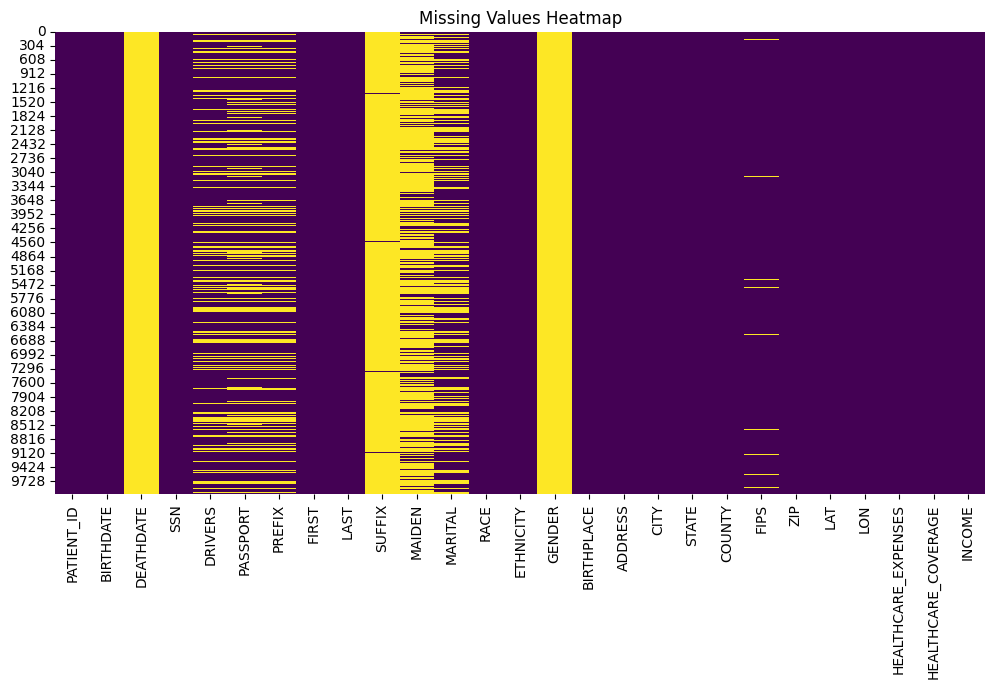

In [6]:
# 3. Visualizations

# 3.1 Missing Values Heatmap
def plot_missing_values(df):
    plt.figure(figsize=(12, 6))
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
    plt.title('Missing Values Heatmap')
    plt.show()

plot_missing_values(patients_df)

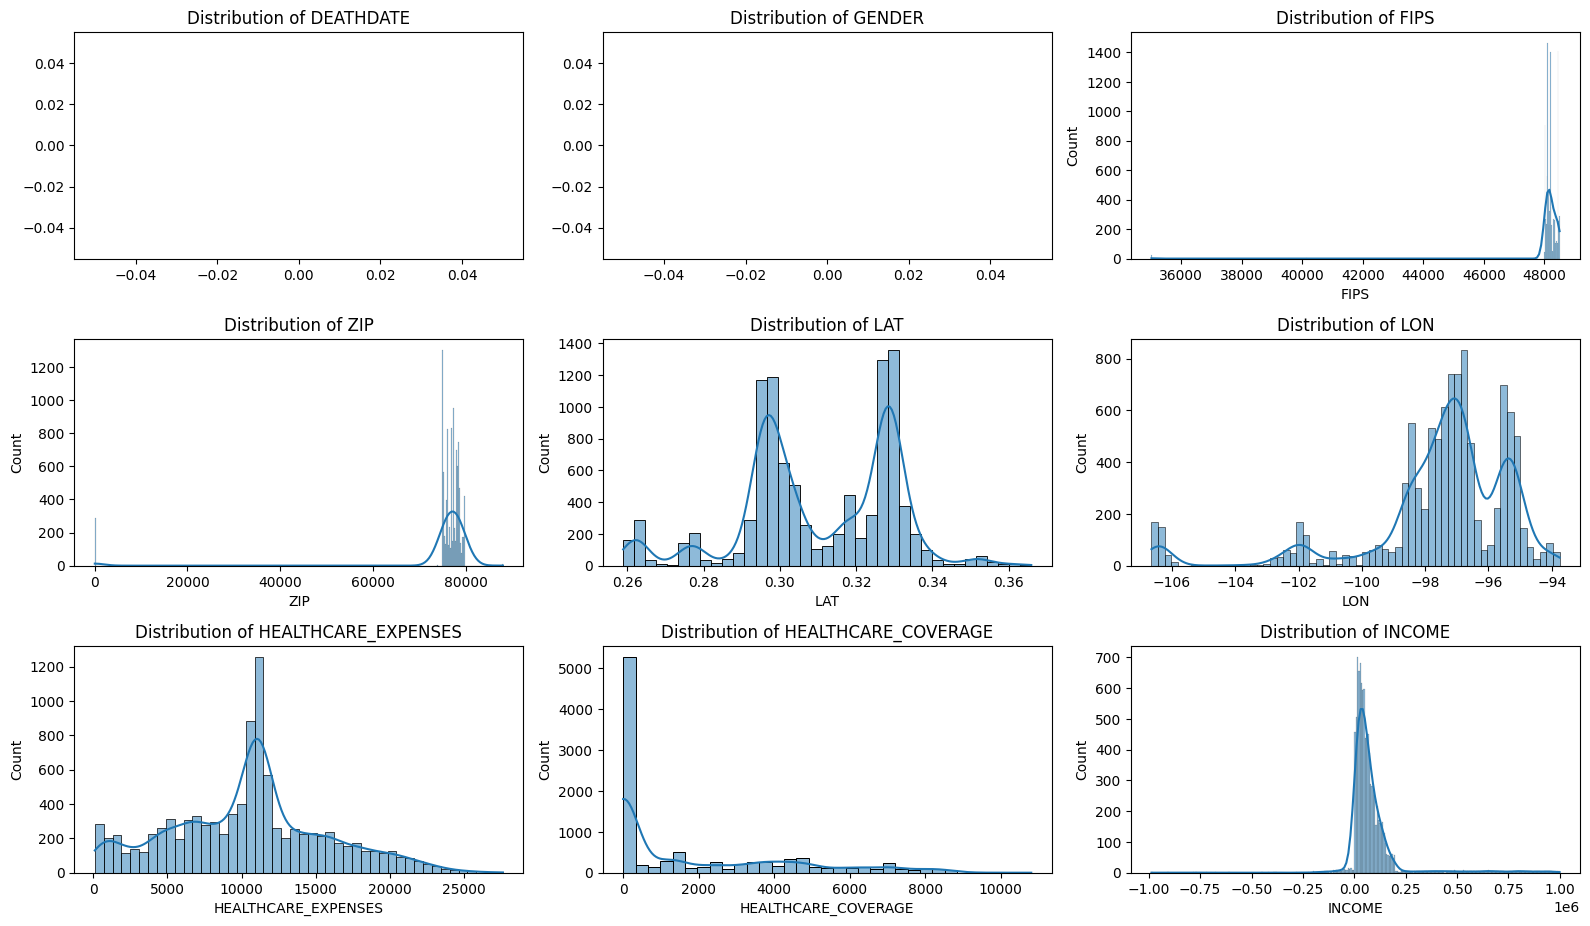

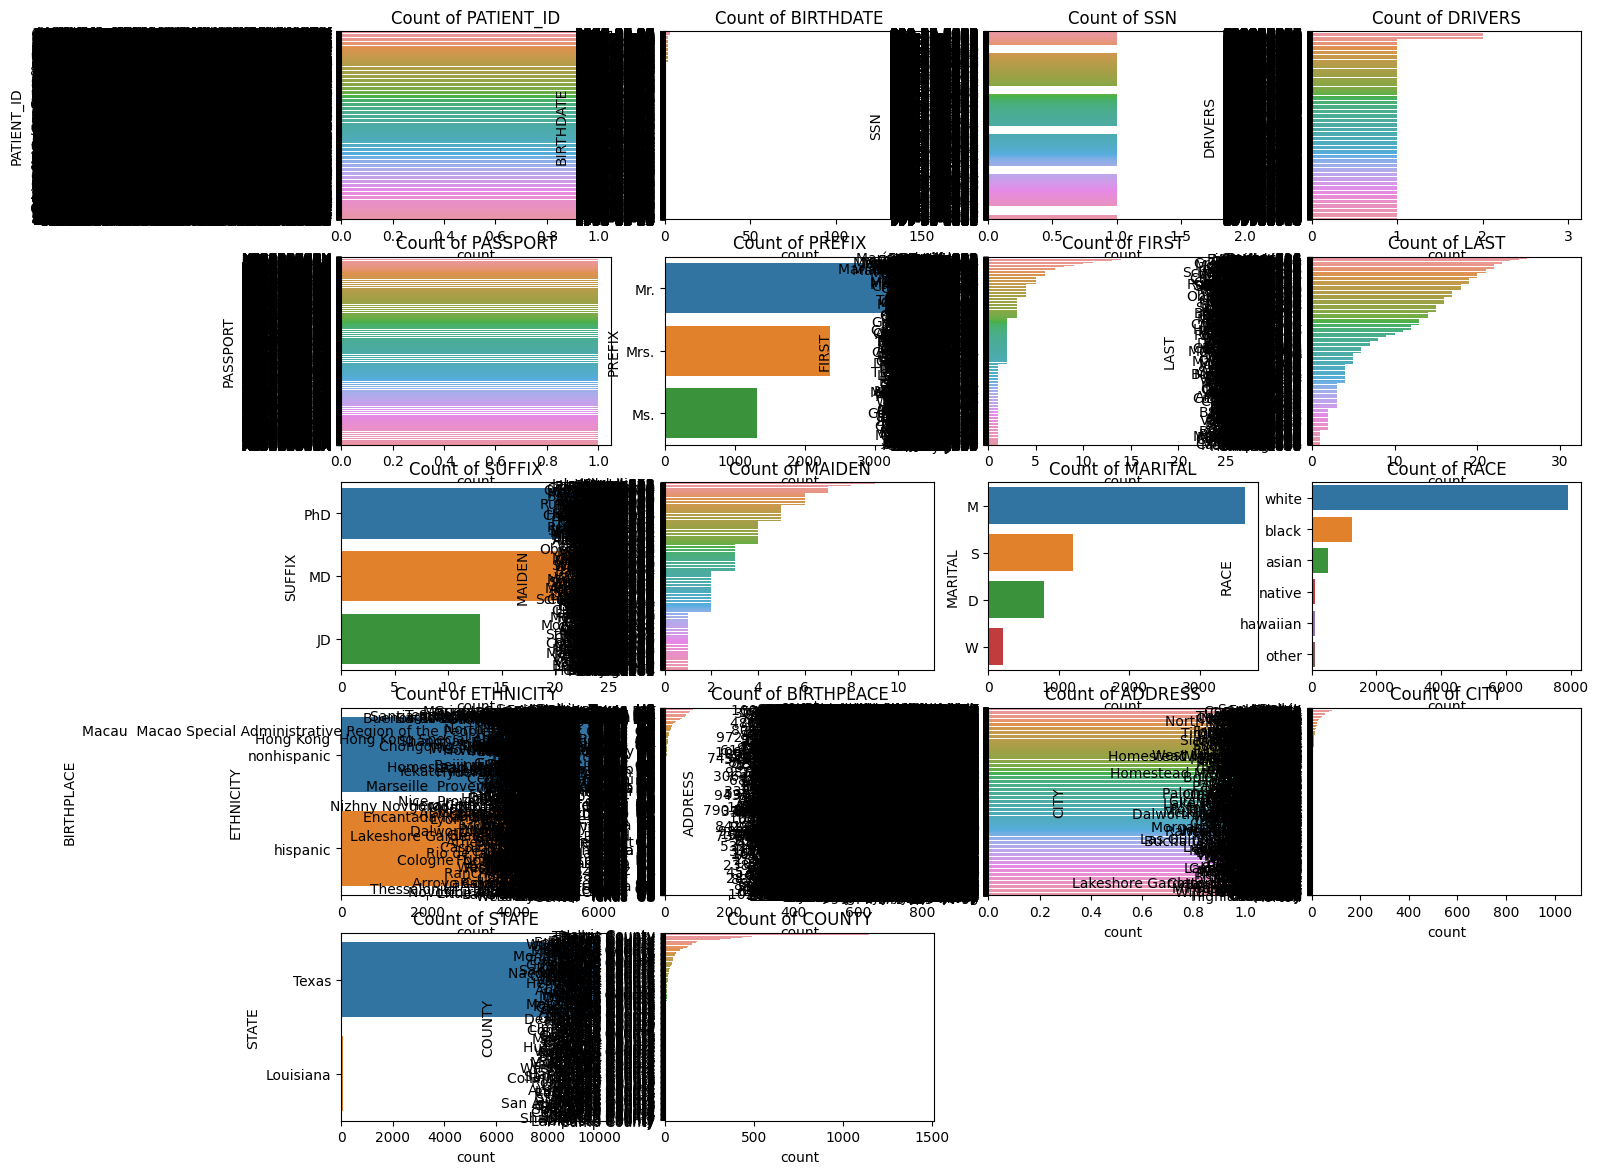

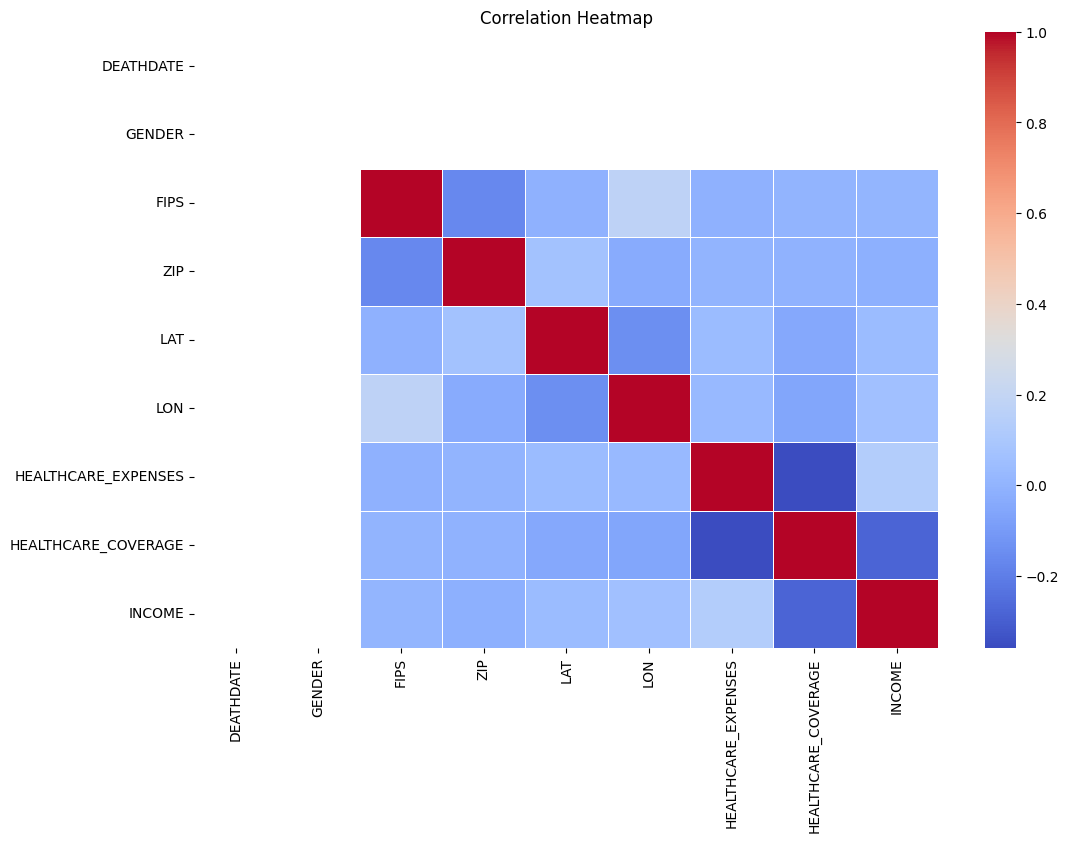

In [7]:
# 3.2 Distribution of Numerical Columns
def plot_numerical_distributions(df):
    numerical_columns = df.select_dtypes(include=[np.number]).columns.tolist()
    
    plt.figure(figsize=(16, 12))
    for i, col in enumerate(numerical_columns, 1):
        plt.subplot(4, 3, i)
        sns.histplot(df[col].dropna(), kde=True)
        plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

plot_numerical_distributions(patients_df)

# 3.3 Count of Categorical Columns
def plot_categorical_counts(df):
    categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
    
    plt.figure(figsize=(16, 20))
    for i, col in enumerate(categorical_columns, 1):
        plt.subplot(7, 4, i)
        sns.countplot(y=df[col], order=df[col].value_counts().index)
        plt.title(f'Count of {col}')
    plt.tight_layout()
    plt.show()

plot_categorical_counts(patients_df)

# 3.4 Correlation Heatmap
def plot_correlation_heatmap(df):
    plt.figure(figsize=(12, 8))
    correlation_matrix = df.select_dtypes(include=[np.number]).corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
    plt.title('Correlation Heatmap')
    plt.show()

plot_correlation_heatmap(patients_df)

In [10]:
# 4. Summary of Issues
def summarize_issues(df):
    print("\nSummary of Data Quality Issues:")
    
    # Check for missing values
    missing_values = df.isnull().sum()
    print("\nMissing Values:")
    print(missing_values[missing_values > 0])
    
    # Check for duplicate records
    duplicate_count = df.duplicated().sum()
    print("\nDuplicate Records:", duplicate_count)
    
    # Check for invalid data
    print("\nInvalid Data Checks (Example):")
    # Example: Check if all SSNs start with '999' (could be invalid or placeholder)
    invalid_ssns = df['SSN'].str.startswith('999').sum()
    print("SSNs starting with '999':", invalid_ssns)
    
    # Check for outliers (e.g., latitudes and longitudes)
    print("\nOutlier Checks:")
    numerical_columns = df.select_dtypes(include=[np.number]).columns.tolist()
    for col in numerical_columns:
        if col not in ['latitude', 'longitude']:  # Skipping lat/long here for simplicity
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            iqr = q3 - q1
            outliers = ((df[col] < (q1 - 1.5 * iqr)) | (df[col] > (q3 + 1.5 * iqr))).sum()
            print(f"Outliers in {col}:", outliers)

summarize_issues(patients_df)


Summary of Data Quality Issues:

Missing Values:
DEATHDATE    10000
DRIVERS       2320
PASSPORT      2961
PREFIX        2663
SUFFIX        9941
MAIDEN        7648
MARITAL       4146
GENDER       10000
FIPS           290
dtype: int64

Duplicate Records: 0

Invalid Data Checks (Example):
SSNs starting with '999': 10000

Outlier Checks:
Outliers in DEATHDATE: 0
Outliers in GENDER: 0
Outliers in FIPS: 26
Outliers in ZIP: 300
Outliers in LAT: 0
Outliers in LON: 849
Outliers in HEALTHCARE_EXPENSES: 88
Outliers in HEALTHCARE_COVERAGE: 7
Outliers in INCOME: 617


In [6]:
# Load datasets
patients_df = catalog.load("patients")

[07/20/24 13:34:14] INFO     Loading data from patients (CSVDataset)...                         ]8;id=816985;file:///opt/anaconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=423463;file:///opt/anaconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#508\508]8;;\

In [33]:
# Load datasets
patients_df = catalog.load("patients")

# Define the updated column mapping
column_mapping = {
    'PATIENT_ID': 'patient_id',
    'FIRST': 'first_name',
    'LAST': 'last_name',
    'GENDER': 'sex',
    'RACE': 'race',
    'BIRTHDATE': 'birth_date',
    'DEATHDATE': 'death_date',
    'SSN': 'social_security_number',
    'ADDRESS': 'address',
    'CITY': 'city',
    'STATE': 'state',
    'ZIP': 'zip_code',
    'COUNTY': 'county',
    'LAT': 'latitude',
    'LON': 'longitude',
    'INCOME':'income',
}


# Rename columns
patients_df.rename(columns=column_mapping, inplace=True)

# Summary of findings
summary = {
    'total_records': len(patients_df),
    'invalid_birth_dates_removed': len(patients_df[patients_df['birth_date'] == '9999-99-99']),
    'invalid_ssn_removed': len(patients_df[~patients_df['social_security_number'].str.match(r'\d{3}-\d{2}-\d{4}')]),
    'invalid_zip_removed': len(patients_df[~patients_df['zip_code'].astype(str).str.match(r'^\d{5}$')]),
    'invalid_lat_lon_removed': len(patients_df[(~patients_df['latitude'].between(-90, 90)) | (~patients_df['longitude'].between(-180, 180))]),
    'negative_income_removed': len(patients_df[patients_df['income'] < 0])
}

# Remove columns with all null values
patients_df.drop(columns=['death_date', 'sex'], inplace=True)

# Add death_flag column
# patients_df['death_flag'] = patients_df['death_date'].notnull()

# Validate and clean the data
# Remove invalid birth dates
patients_df = patients_df[patients_df['birth_date'] != '9999-99-99']

# Ensure SSN format is valid
patients_df = patients_df[patients_df['social_security_number'].str.match(r'\d{3}-\d{2}-\d{4}')]

# Ensure ZIP code is a valid 5-digit number
patients_df = patients_df[patients_df['zip_code'].astype(str).str.match(r'^\d{5}$')]

# Ensure LAT and LON are valid geographical coordinates
patients_df = patients_df[(patients_df['latitude'].between(-90, 90)) & (patients_df['longitude'].between(-180, 180))]

# # Remove Outliers 
Q1 = patients_df['HEALTHCARE_EXPENSES'].quantile(0.25)
Q3 = patients_df['HEALTHCARE_EXPENSES'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
    
# patients_df['HEALTHCARE_EXPENSES'] = np.where((patients_df['HEALTHCARE_EXPENSES'] < lower_bound) | (patients_df['HEALTHCARE_EXPENSES'] > upper_bound), np.nan, patients_df['HEALTHCARE_EXPENSES'])
patients_df = patients_df[(patients_df['HEALTHCARE_EXPENSES'] > lower_bound) | (patients_df['HEALTHCARE_EXPENSES'] < upper_bound)]

# Calculate age and age group
current_year = pd.to_datetime('today').year
patients_df['age'] = current_year - pd.to_datetime(patients_df['birth_date']).dt.year
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']
patients_df['age_group'] = pd.cut(patients_df['age'], bins=bins, labels=labels, right=False)

patients_df = patients_df[patients_df['income'] > 0]

print(len(patients_df))

print("Data Quality Summary:", summary)

[07/22/24 12:54:50] INFO     Loading data from patients (CSVDataset)...                         ]8;id=578757;file:///opt/anaconda3/envs/kedro-environment/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=889987;file:///opt/anaconda3/envs/kedro-environment/lib/python3.8/site-packages/kedro/io/data_catalog.py#508\508]8;;\

9371
Data Quality Summary: {'total_records': 10000, 'invalid_birth_dates_removed': 150, 'invalid_ssn_removed': 0, 'invalid_zip_removed': 290, 'invalid_lat_lon_removed': 0, 'negative_income_removed': 200}


In [40]:
import great_expectations as ge
from great_expectations.data_context import DataContext
import great_expectations as gx
from great_expectations.core.batch import Batch
from great_expectations.core.batch import BatchRequest
from great_expectations.data_context import DataContext

In [42]:
import great_expectations as ge
from great_expectations.data_context import DataContext
import great_expectations as gx
from great_expectations.core.batch import Batch
from great_expectations.core.batch import BatchRequest
from great_expectations.data_context import DataContext

# Convert to a Great Expectations DataFrame
ge_df = PandasDataset(patients_df)
    
# Load the expectation suite
expectation_suite_name = "cleaned_patients_asset_name.warning"
suite = context.get_expectation_suite(expectation_suite_name)

# Create a BatchRequest
batch_request = BatchRequest(
        datasource_name="your_datasource_name",
        data_connector_name="your_data_connector_name",
        data_asset_name="your_data_asset_name",
        batch_identifiers={},
)
    
# Get the Batch from the DataContext
batch = context.get_batch(batch_request=batch_request)
# Create a Batch
batch = context.get_batch(batch_request=batch_request)
    

    





╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:16                                                                                   │
│                                                                                                  │
│   13 suite = context.get_expectation_suite(expectation_suite_name)                               │
│   14                                                                                             │
│   15 # Create a BatchRequest                                                                     │
│ ❱ 16 batch_request = BatchRequest(                                                               │
│   17 │   │   datasource_name="your_datasource_name",                                             │
│   18 │   │   data_connector_name="your_data_connector_name",                                     │
│   19 │   │   data_asset_name="your_data_asset_name",                                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: __init__() got an unexpected keyword argument 'batch_identifiers'

In [55]:
import great_expectations as ge

# Initialize GE context
context = ge.get_context()

# Convert to a Great Expectations DataFrame
ge_df = ge.from_pandas(patients_df)

# Load the expectation suite
expectation_suite_name = "cleaned_patients_asset_name.warning"
suite = context.get_expectation_suite(expectation_suite_name=expectation_suite_name)

# Load the expectation suite
try:
        suite = context.get_expectation_suite(expectation_suite_name=expectation_suite_name)
        print(f'Loaded ExpectationSuite "{suite.expectation_suite_name}" containing {len(suite.expectations)} expectations.')
except:
        print(f'Expectation suite "{expectation_suite_name}" does not exist.')
        # Optionally create a new suite if needed
        # suite = context.add_expectation_suite(expectation_suite_name=expectation_suite_name)

# Perform the validation
validation_result = context.run_validation_operator(
    "action_list_operator",
    assets_to_validate=[ge_df],
    run_id="patients_validation"
)

# Print the validation result
print(validation_result)
    
# Validate the data against the expectations
results = context.run_validation_operator(
        "action_list_operator",
        ge_df,
        expectation_suite_name=expectation_suite_name,
        result_format="SUMMARY"  # Options: "SUMMARY", "COMPLETE", "BASIC"
)
#     # Print the results
# # print("Validation Results:")
# # print(results)


[07/22/24 13:30:10] WARNING  You appear to be using a legacy capability with the latest config version ]8;id=360764;file:///opt/anaconda3/envs/kedro-environment/lib/python3.8/site-packages/great_expectations/data_context/types/base.py\base.py]8;;\:]8;id=42156;file:///opt/anaconda3/envs/kedro-environment/lib/python3.8/site-packages/great_expectations/data_context/types/base.py#1784\1784]8;;\
                             (3.0).                                                                                
                                 Your data context with this configuration version uses                            
                             validation_operators, which are being deprecated.  Please consult the V3              
                             API migration guide                                                                   
                             https://docs.greatexpectations.io/docs/guides/miscellaneous/migration_gui             
                             de#migrating-to-the-batch-request-v3-api and update your configuration to             
                             be compatible with the version number 3.                                              
                                 (This message will appear repeatedly until your configuration is                  
                             updated.)                                                                             
                                                                                                                   

Loaded ExpectationSuite "cleaned_patients_asset_name.warning" containing 6 expectations.
{
  "run_id": {
    "run_name": null,
    "run_time": "2024-07-22T13:30:10.637661+05:30"
  },
  "run_results": {
    "ValidationResultIdentifier::default/__none__/20240722T080010.637661Z/ge_batch_id=6b2147ac-4800-11ef-b945-acde48001122": {
      "validation_result": {
        "success": true,
        "results": [],
        "evaluation_parameters": {},
        "statistics": {
          "evaluated_expectations": 0,
          "successful_expectations": 0,
          "unsuccessful_expectations": 0,
          "success_percent": null
        },
        "meta": {
          "great_expectations_version": "0.18.19",
          "expectation_suite_name": "default",
          "run_id": {
            "run_name": null,
            "run_time": "2024-07-22T13:30:10.637661+05:30"
          },
          "batch_kwargs": {
            "ge_batch_id": "6b2147ac-4800-11ef-b945-acde48001122"
          },
          "batch_mar

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:33                                                                                   │
│                                                                                                  │
│   30 print(validation_result)                                                                    │
│   31                                                                                             │
│   32 # Validate the data against the expectations                                                │
│ ❱ 33 results = context.run_validation_operator(                                                  │
│   34 │   │   "action_list_operator",                                                             │
│   35 │   │   ge_df,                                                                              │
│   36 │   │   expectation_suite_name=expectation_suite_name,                                      │
│                                                                                                  │
│ /opt/anaconda3/envs/kedro-environment/lib/python3.8/site-packages/great_expectations/core/usage_ │
│ statistics/usage_statistics.py:266 in usage_statistics_wrapped_method                            │
│                                                                                                  │
│   263 │   │   │   │   │   args_payload = args_payload_fn(*args, **kwargs) or {}                  │
│   264 │   │   │   │   │   nested_update(event_payload, args_payload)                             │
│   265 │   │   │   │                                                                              │
│ ❱ 266 │   │   │   │   result = func(*args, **kwargs)                                             │
│   267 │   │   │   │   message["success"] = True                                                  │
│   268 │   │   │   except Exception:                                                              │
│   269 │   │   │   │   message["success"] = False                                                 │
│                                                                                                  │
│ /opt/anaconda3/envs/kedro-environment/lib/python3.8/site-packages/great_expectations/data_contex │
│ t/data_context/abstract_data_context.py:3441 in run_validation_operator                          │
│                                                                                                  │
│   3438 │   │   Returns:                                                                          │
│   3439 │   │   │   ValidationOperatorResult                                                      │
│   3440 │   │   """                                                                               │
│ ❱ 3441 │   │   return self._run_validation_operator(                                             │
│   3442 │   │   │   validation_operator_name=validation_operator_name,                            │
│   3443 │   │   │   assets_to_validate=assets_to_validate,                                        │
│   3444 │   │   │   run_id=run_id,                                                                │
│                                                                                                  │
│ /opt/anaconda3/envs/kedro-environment/lib/python3.8/site-packages/great_expectations/data_contex │
│ t/data_context/abstract_data_context.py:3465 in _run_validation_operator                         │
│                                                                                                  │
│   3462 │   ):                                                                                    │
│   3463 │   │   result_format = result_format or {"result_format": "SUMMARY"}                     │
│   3464 │   │                                                                                     │
│ ❱ 3465 │   │   if not assets_to_validate:                  

In [57]:
import great_expectations as ge
import pandas as pd

# Assume patients_df is already defined
# patients_df = pd.read_csv("path_to_your_patients_csv")

# Initialize GE context
context = ge.get_context()

# Convert to a Great Expectations DataFrame
ge_df = ge.from_pandas(patients_df)

# Define the expectation suite name
expectation_suite_name = "cleaned_patients_asset_name.warning"

# Load the expectation suite or create a new one
try:
    suite = context.get_expectation_suite(expectation_suite_name=expectation_suite_name)
    print(f'Loaded ExpectationSuite "{suite.expectation_suite_name}" containing {len(suite.expectations)} expectations.')
except ge.exceptions.DataContextError:
    print(f'Expectation suite "{expectation_suite_name}" does not exist. Creating a new one.')
    suite = context.add_expectation_suite(expectation_suite_name=expectation_suite_name)

# # Define expectations
# ge_df.expect_column_to_exist("patient_id")
# ge_df.expect_column_values_to_be_unique("patient_id")
# ge_df.expect_column_values_to_match_regex("social_security_number", "\\d{3}-\\d{2}-\\d{4}", 
#     meta={"notes": {"content": "Expect SSN to match the pattern ###-##-####", "format": "markdown"}})
# ge_df.expect_column_values_to_match_regex("zip_code", "^\\d{5}$", 
#     meta={"notes": {"content": "Expect ZIP Code to be exactly 5 digits", "format": "markdown"}})
# ge_df.expect_column_values_to_be_between("latitude", min_value=-90, max_value=90, 
#     meta={"notes": {"content": "Expect latitude to be between -90 and 90 degrees", "format": "markdown"}})
# ge_df.expect_column_values_to_be_between("longitude", min_value=-180, max_value=180, 
#     meta={"notes": {"content": "Expect longitude to be between -180 and 180 degrees", "format": "markdown"}})

# # Save expectations to suite
# suite.expectations = ge_df.get_expectation_suite().expectations
# context.save_expectation_suite(expectation_suite=suite, expectation_suite_name=expectation_suite_name)

# Perform the validation
validation_result = context.run_validation_operator(
    "action_list_operator",
    assets_to_validate=[ge_df],
    run_id="patients_validation"
)

# Print the validation result
print(validation_result)


[07/22/24 13:42:23] WARNING  You appear to be using a legacy capability with the latest config version ]8;id=247596;file:///opt/anaconda3/envs/kedro-environment/lib/python3.8/site-packages/great_expectations/data_context/types/base.py\base.py]8;;\:]8;id=975683;file:///opt/anaconda3/envs/kedro-environment/lib/python3.8/site-packages/great_expectations/data_context/types/base.py#1784\1784]8;;\
                             (3.0).                                                                                
                                 Your data context with this configuration version uses                            
                             validation_operators, which are being deprecated.  Please consult the V3              
                             API migration guide                                                                   
                             https://docs.greatexpectations.io/docs/guides/miscellaneous/migration_gui             
                             de#migrating-to-the-batch-request-v3-api and update your configuration to             
                             be compatible with the version number 3.                                              
                                 (This message will appear repeatedly until your configuration is                  
                             updated.)                                                                             
                                                                                                                   

Loaded ExpectationSuite "cleaned_patients_asset_name.warning" containing 6 expectations.
{
  "run_id": {
    "run_name": null,
    "run_time": "2024-07-22T13:42:23.780864+05:30"
  },
  "run_results": {
    "ValidationResultIdentifier::default/__none__/20240722T081223.780864Z/ge_batch_id=201d89f8-4802-11ef-b945-acde48001122": {
      "validation_result": {
        "success": true,
        "results": [],
        "evaluation_parameters": {},
        "statistics": {
          "evaluated_expectations": 0,
          "successful_expectations": 0,
          "unsuccessful_expectations": 0,
          "success_percent": null
        },
        "meta": {
          "great_expectations_version": "0.18.19",
          "expectation_suite_name": "default",
          "run_id": {
            "run_name": null,
            "run_time": "2024-07-22T13:42:23.780864+05:30"
          },
          "batch_kwargs": {
            "ge_batch_id": "201d89f8-4802-11ef-b945-acde48001122"
          },
          "batch_mar